In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, roc_auc_score, f1_score, precision_recall_curve
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from imblearn.over_sampling import RandomOverSampler

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB

import warnings
warnings.filterwarnings("ignore")

In [2]:
# DataFrame with the main information about clients with TARGET
df_train = pd.read_csv('data/application_train.csv')

# DataFrame with the main information about clients without TARGET
df_test = pd.read_csv('data/application_test_student.csv')

# DataFrame with information about credits from other financials institutions
df_bur = pd.read_csv('data/bureau.csv')

# Monthly balances of previous credits in credit bureau
df_bur_balance = pd.read_csv('data/bureau_balance.csv')

# Monthly balances snapshots of previous credit cards that the applicant has with Home Credit
df_cred_card = pd.read_csv('data/credit_card_balance.csv')

# Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample
df_inst_pay = pd.read_csv('data/installments_payments.csv')
 
# Monthly balance of previous POS (Point of Sales) and cash loans that the applicant had with Home Credit 
df_pos = pd.read_csv('data/POS_CASH_balance.csv')

# Previous loans of clients with Home Credit
df_prev_app = pd.read_csv('data/previous_application.csv')

# Inserting new features through extra tables

## External bureaus features

From external bureaus features 'bureau.csv' and 'bureau_balance.csv', we extract the following features to the main dataframes:

* 'amt_credit_max_overdue_ext_bur': Maximal amount overdue of each customer in external bureaus     

* 'cnt_credit_prolong_ext_bur': Total times was the Credit Bureau credit prolonged

* 'amt_credit_sum_overdue_ext_bur': Sum of amounts overdue of each customer in external bureaus 

* 'months_with_delayed_payment_reported_ext_bur': Months reported of payment delay of each customers in external bureaus

* 'amt_credit_to_pay_ext_bur': Amount of credit to pay for each customer in external bureaus

* 'flag_has_credit_active_ext_bur': Flag if the customer has an active credit in external bureaus

In [3]:
# First we will collect information from the bureau_balance.csv where the client has delayed at least one payment
# and then merge to bureau.csv informations
df_bur_balance['STATUS'] = np.where(df_bur_balance['STATUS'].isin(['C', 'X', '0']), 0, 1)
df_bur_balance_to_merge = df_bur_balance.groupby(['SK_ID_BUREAU'])['STATUS'].sum().reset_index().rename(columns={'STATUS': 'months_with_delayed_payment_reported_ext_bur'})
df_bur_merged = df_bur.merge(df_bur_balance_to_merge, on='SK_ID_BUREAU', how='left')

# Now merge to bureau.csv
df_bur_merged['months_with_delayed_payment_reported_ext_bur'] = df_bur_merged['months_with_delayed_payment_reported_ext_bur']

In [4]:
# We combine the features AMT_CREDIT_SUM and AMT_CREDIT_SUM_DEBT to obtain the amount of each customer in each bureau has still to pay
df_bur_merged['amt_credit_to_pay_ext_bur']  = df_bur_merged['AMT_CREDIT_SUM'] - df_bur_merged['AMT_CREDIT_SUM_DEBT']

# We will set 0 to the customers that has not an active credit 
# (WE WILL NOT TAKING ACCOUNT THE CUSTOMERS WITH BAD DEPT AND THE LOAN WAS SOLD)
df_bur_merged['flag_has_credit_active_ext_bur'] = np.where(df_bur_merged['CREDIT_ACTIVE'] == 'Closed', 0, 1)

# Now we drop the features we believe will not help us to predict default 
df_bur_merged = df_bur_merged.drop(columns=['AMT_ANNUITY', 'DAYS_CREDIT_UPDATE', 'CREDIT_TYPE', 
                                            'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_DEBT', 
                                            'AMT_CREDIT_SUM', 'DAYS_ENDDATE_FACT', 'DAYS_CREDIT_ENDDATE', 
                                            'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT', 'CREDIT_CURRENCY', 
                                            'SK_ID_BUREAU', 'CREDIT_ACTIVE'])

In [5]:
# Now we prepare the dataset to be merged with the main datasets
# First, from the columns we select, we can replace the NaN values to zero
df_bur_merged.fillna(0)

# As one client can have multiple rows we will agreggate as the follos
aggregations = {'AMT_CREDIT_MAX_OVERDUE': 'sum',
                'CNT_CREDIT_PROLONG': 'sum', 
                'AMT_CREDIT_SUM_OVERDUE': 'sum',
                'months_with_delayed_payment_reported_ext_bur': 'sum',
                'amt_credit_to_pay_ext_bur': 'sum',
                'flag_has_credit_active_ext_bur': 'sum'}

df_bur_final = df_bur_merged.groupby(['SK_ID_CURR']).agg(aggregations).reset_index()

# We will fix the flag because one client could be flagged more than once during agreggations
df_bur_final['flag_has_credit_active_ext_bur'] = np.where(df_bur_final['flag_has_credit_active_ext_bur'] == 0, 0, 1)

# To make the main dataset readable we will keep the lower case notation and 'ext_bur' at the end of feature
# to now where the feature came from
df_bur_final = df_bur_final.rename(columns={'AMT_CREDIT_MAX_OVERDUE': 'amt_credit_max_overdue_ext_bur', 
                                            'CNT_CREDIT_PROLONG': 'cnt_credit_prolong_ext_bur', 
                                            'AMT_CREDIT_SUM_OVERDUE': 'amt_credit_sum_overdue_ext_bur'})

In [6]:
# Finnaly, we merge it to the main dataset
df_train = df_train.merge(df_bur_final, on='SK_ID_CURR', how='left')
df_test = df_test.merge(df_bur_final, on='SK_ID_CURR', how='left')

# The NaN values in main datasets should be zero as well
_ = ['amt_credit_max_overdue_ext_bur',
       'cnt_credit_prolong_ext_bur', 'amt_credit_sum_overdue_ext_bur',
       'months_with_delayed_payment_reported_ext_bur',
       'amt_credit_to_pay_ext_bur', 'flag_has_credit_active_ext_bur']

df_train[_] = df_train[_].fillna(0)
df_test[_] = df_test[_].fillna(0)

## POS and CASH balance

From point of sales and cash loans features 'POS_CASH_balance.csv', we extract the following features to the main dataframes:
* 'dpd_internal_pos_cash': Sum of days past due of each customer during the month with tolerance (credit and cash loans of Home Credit)

In [7]:
df_pos.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [8]:
# We can see that the clients who DPD more than 5 day has more than 10% in defaults
_ = df_pos[df_pos['SK_DPD_DEF']>=5]['SK_ID_CURR'].unique()

df_train[df_train['SK_ID_CURR'].isin(_)]['TARGET'].value_counts(normalize=True)

0    0.881042
1    0.118958
Name: TARGET, dtype: float64

In [9]:
# We will merge only the feature SK_DPD_DEF on the main datasets
df_pos_to_merge = df_pos.groupby('SK_ID_CURR')['SK_DPD_DEF'].sum().reset_index().rename(columns={'SK_DPD_DEF': 'dpd_internal_pos_cash'})
df_train = df_train.merge(df_pos_to_merge, on='SK_ID_CURR', how='left')
df_test = df_test.merge(df_pos_to_merge, on='SK_ID_CURR', how='left')

# Replace NaN values to zero
df_train['dpd_internal_pos_cash'] = df_train['dpd_internal_pos_cash'].fillna(0)
df_test['dpd_internal_pos_cash'] = df_test['dpd_internal_pos_cash'].fillna(0)

## Installments payments

From installments features 'POS_CASH_balance.csv', we extract the following features to the main dataframes:
* 'days_delayed_payment_inst_pay': Sum of days delayed on installments of previous loans
* 'amt_not_paid_inst_pay': Sum of the amounts not paid on previous installments

In [10]:
df_inst_pay.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [11]:
# We create two new features to represent the days delayed to pay the instalment and amount not paid
df_inst_pay['days_delayed_payment_inst_pay'] = df_inst_pay['DAYS_ENTRY_PAYMENT'] - df_inst_pay['DAYS_INSTALMENT']
df_inst_pay['amt_not_paid_inst_pay'] = df_inst_pay['AMT_INSTALMENT'] - df_inst_pay['AMT_PAYMENT']

In [12]:
# We aggregate the new features created taking account the max days and sum not paid 
aggregations = {'days_delayed_payment_inst_pay': 'max',
                'amt_not_paid_inst_pay': 'sum'}

df_inst_pay_to_merge = df_inst_pay.groupby('SK_ID_CURR')[['days_delayed_payment_inst_pay', 'amt_not_paid_inst_pay']].agg(aggregations).reset_index()

df_inst_pay_to_merge.head()

,SK_ID_CURR,days_delayed_payment_inst_pay,amt_not_paid_inst_pay
0,100001,11.0,0.0
1,100002,-12.0,0.0
2,100003,-1.0,0.0
3,100004,-3.0,0.0
4,100005,1.0,0.0


In [13]:
# Finnaly we merge into the main dataframes
df_train = df_train.merge(df_inst_pay_to_merge, on='SK_ID_CURR', how='left')
df_train[['days_delayed_payment_inst_pay', 'amt_not_paid_inst_pay']] = df_train[['days_delayed_payment_inst_pay', 'amt_not_paid_inst_pay']].fillna(0)

df_test = df_test.merge(df_inst_pay_to_merge, on='SK_ID_CURR', how='left')
df_test[['days_delayed_payment_inst_pay', 'amt_not_paid_inst_pay']] = df_test[['days_delayed_payment_inst_pay', 'amt_not_paid_inst_pay']].fillna(0)

## Credit card balance

From credit card features 'credit_card_balance.csv', we extract the following features to the main dataframes:

* 'dpd_cred_card_cd': Sum of days past due in credit card payments

* 'var_credit_lim_cd': Variation of the max credit card limit and the month before application credit card limit

PS: The variation variable was created to see if there is a relationship between decreasing credit card limit and default. 

In [14]:
df_cred_card.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [15]:
# We will create a feature to see if the credit card limit decreases to the month before application
_max = df_cred_card.groupby('SK_ID_CURR')['AMT_CREDIT_LIMIT_ACTUAL'].max()
_last = df_cred_card[df_cred_card['MONTHS_BALANCE']==-1].groupby('SK_ID_CURR')['AMT_CREDIT_LIMIT_ACTUAL'].sum()

_var = _last - _max
_var = _var.reset_index().rename(columns={'AMT_CREDIT_LIMIT_ACTUAL': 'var_credit_lim_cd'})

# We will collect information about the dpd for credit card payment
_dpd = df_cred_card.groupby('SK_ID_CURR', as_index=False)['SK_DPD_DEF'].max().rename(columns={'SK_DPD_DEF': 'dpd_cred_card_cd'})

# Create a dataframe to merge with tha main dataframes
_to_merge = _dpd.merge(_var, on='SK_ID_CURR', how='left')

_to_merge.head()

,SK_ID_CURR,dpd_cred_card_cd,var_credit_lim_cd
0,100006,0,0.0
1,100011,0,NaN
2,100013,1,-112500.0
3,100021,0,NaN
4,100023,0,NaN


In [16]:
# Merge to the main dataframes
df_train = df_train.merge(_to_merge, on='SK_ID_CURR', how='left')
df_train[['dpd_cred_card_cd', 'var_credit_lim_cd']] = df_train[['dpd_cred_card_cd', 'var_credit_lim_cd']].fillna(0)

df_test = df_test.merge(_to_merge, on='SK_ID_CURR', how='left')
df_test[['dpd_cred_card_cd', 'var_credit_lim_cd']] = df_test[['dpd_cred_card_cd', 'var_credit_lim_cd']].fillna(0)

## Previous application

From previous applications features 'previous_application.csv', we extract the following features to the main dataframes:

* '#_previous_refused_loan': Number of times each customer has refused loan in Home Credit

* 'to_pay_in_prev_app': Amount to pay in Home Credit previous loans of each customer

In [17]:
df_prev_app.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# Creating the number of previous refused loans from previous applications
_ = df_prev_app[df_prev_app['NAME_CONTRACT_STATUS'] == 'Refused']
__ = _.groupby('SK_ID_CURR').agg({'NAME_CONTRACT_STATUS': 'count'}).reset_index().rename(columns={'NAME_CONTRACT_STATUS': '#_previous_refused_loan'})
display(__.head())

df_train = df_train.merge(__, on='SK_ID_CURR', how='left')
df_train['#_previous_refused_loan'] = df_train['#_previous_refused_loan'].fillna(0)

df_test = df_test.merge(__, on='SK_ID_CURR', how='left')
df_test['#_previous_refused_loan'] = df_test['#_previous_refused_loan'].fillna(0)

,SK_ID_CURR,#_previous_refused_loan
0,100006,1
1,100011,1
2,100027,1
3,100030,10
4,100035,8


In [19]:
# Create a test feature, we do not now how to calculate the amount that each client has still to pay on previous application
# Part is because some values on interest rate are NaN, and we think that the total amount of the loan is AMT_CREDIT times (1  + RATE_INTEREST_PRIMARY)

df_prev_app['RATE_INTEREST_PRIMARY'] = df_prev_app['RATE_INTEREST_PRIMARY'].fillna(0.188357)
df_prev_app['total_amt'] = (df_prev_app['RATE_INTEREST_PRIMARY'] + 1) * df_prev_app['AMT_CREDIT']

_paid = df_inst_pay.groupby(['SK_ID_PREV', 'SK_ID_CURR'], as_index=False)['AMT_PAYMENT'].sum()
_topay = df_prev_app[df_prev_app['NAME_CONTRACT_STATUS'] == 'Approved'].groupby(['SK_ID_PREV', 'SK_ID_CURR'], as_index=False)['total_amt'].sum()

_temp = _paid.merge(_topay, on=['SK_ID_PREV', 'SK_ID_CURR'], how='inner').fillna(0)
_temp['to_pay_in_prev_app'] = _temp['total_amt'] - _temp['AMT_PAYMENT']

_temp2 = _temp.groupby('SK_ID_CURR', as_index=False)['to_pay_in_prev_app'].sum()

df_train = df_train.merge(_temp2, on='SK_ID_CURR', how='left')
df_train['to_pay_in_prev_app'] = df_train['to_pay_in_prev_app'].fillna(0)

df_test = df_test.merge(_temp2, on='SK_ID_CURR', how='left')
df_test['to_pay_in_prev_app'] = df_test['to_pay_in_prev_app'].fillna(0)

In [20]:
df_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,months_with_delayed_payment_reported_ext_bur,amt_credit_to_pay_ext_bur,flag_has_credit_active_ext_bur,dpd_internal_pos_cash,days_delayed_payment_inst_pay,amt_not_paid_inst_pay,dpd_cred_card_cd,var_credit_lim_cd,#_previous_refused_loan,to_pay_in_prev_app
0,456162,0,Cash loans,F,N,N,0,112500.0,700830.0,22738.5,...,0.0,399051.000,1.0,0.0,0.0,0.000,0.0,0.0,0.0,2390.590278
1,134978,0,Cash loans,F,N,N,0,90000.0,375322.5,14422.5,...,0.0,3241964.790,1.0,0.0,0.0,-62129.835,0.0,0.0,0.0,172367.695107
2,318952,0,Cash loans,M,Y,N,0,180000.0,544491.0,16047.0,...,0.0,2283747.300,1.0,0.0,-2.0,0.000,0.0,0.0,1.0,5587.535916
3,361264,0,Cash loans,F,N,Y,0,270000.0,814041.0,28971.0,...,0.0,170194.500,1.0,0.0,0.0,383.040,0.0,0.0,2.0,-114754.814816
4,260639,0,Cash loans,F,N,Y,0,144000.0,675000.0,21906.0,...,0.0,1107553.995,1.0,0.0,0.0,0.000,0.0,0.0,1.0,-9659.651058


# Dealing with outliers and incorret data

Concerning to outliers, we just removed one customer whose total amount income is ... 

In [21]:
df_train[(df_train['AMT_INCOME_TOTAL'] > 100000000)]['AMT_INCOME_TOTAL']

159421    117000000.0
Name: AMT_INCOME_TOTAL, dtype: float64

The following boxplots given a general look in how the numeric data is distributed

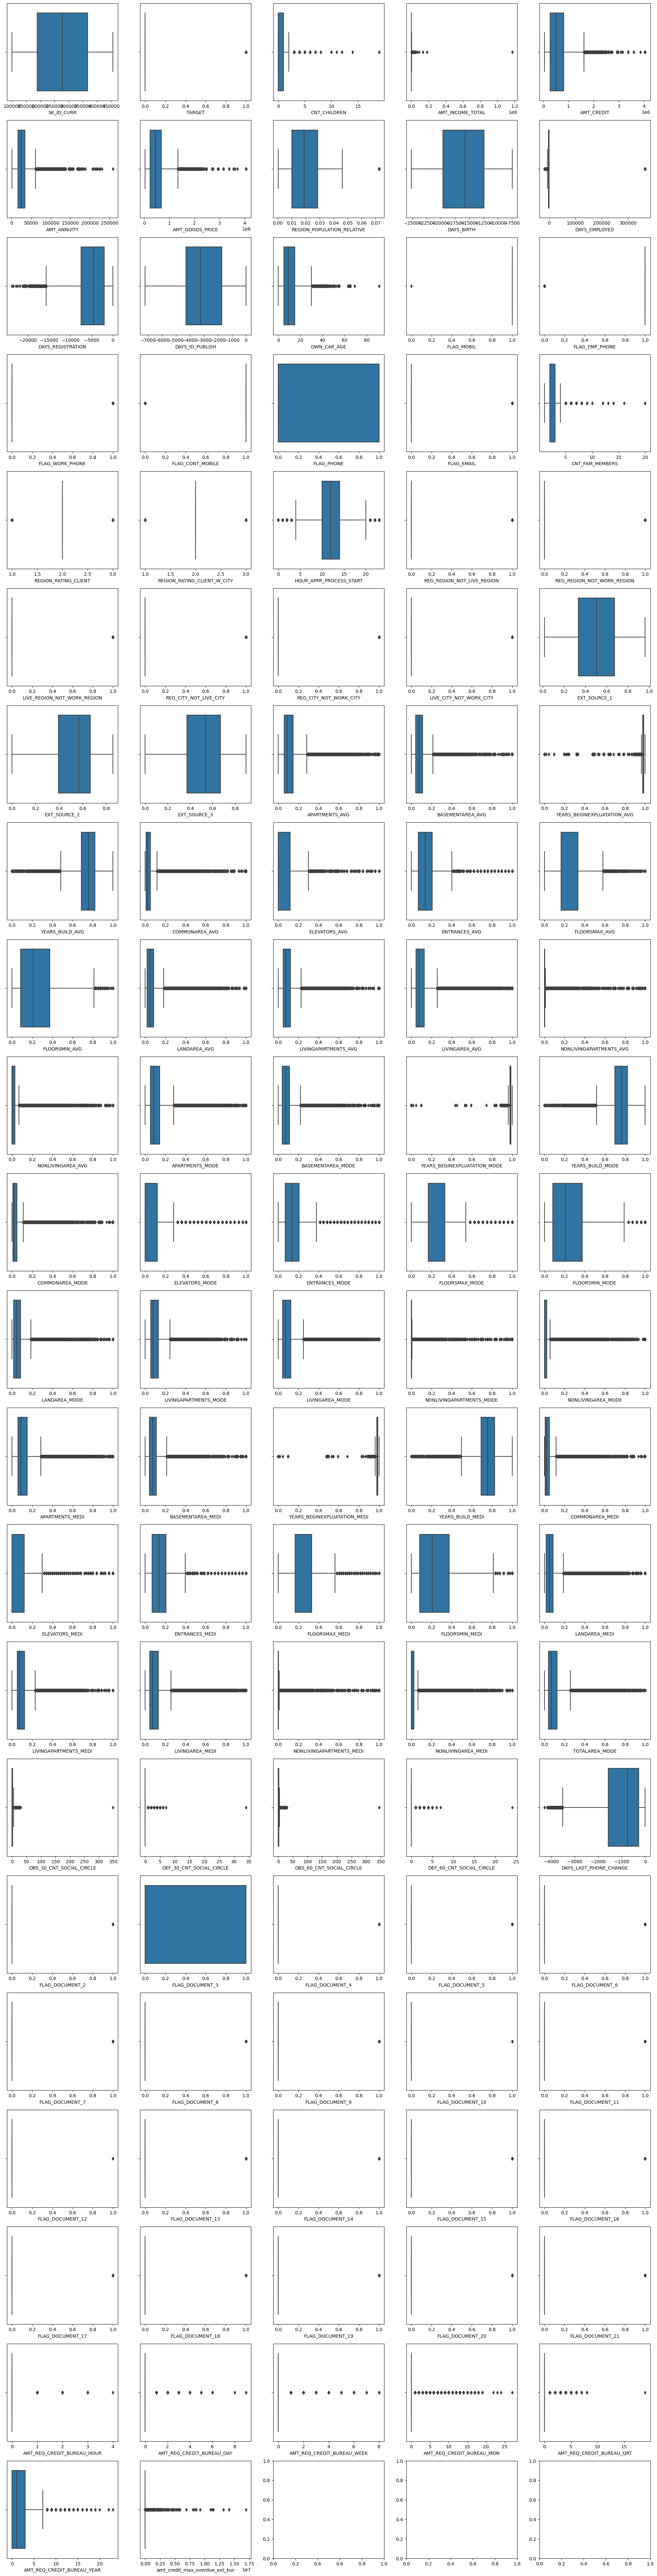

In [22]:
num_cols = df_train.select_dtypes(include='number').columns

fig, axs = plt.subplots(nrows=22, ncols=5, figsize=(25, 100))
k = 0
for i in range(22):
    for j in range(5):
        if k < 107:
            sns.boxplot(data=df_train, x=num_cols[k], ax=axs[i][j])
            k += 1

In [23]:
# Droping some "really" outliers
print(f'The shape before removing outliers: {df_train.shape}')
df_train = df_train[(df_train['AMT_INCOME_TOTAL'] < 100000000)]
print(f'The shape after removing outliers: {df_train.shape}')

The shape before removing outliers: (246008, 135)
The shape after removing outliers: (246007, 135)


We realize that some customers has 365243 days employed, that is 1000 years. We think these customers never worked before, so we input these values to 0

In [24]:
df_train['days_employed'] = np.where(df_train['DAYS_EMPLOYED'] == 365243, 0, df_train['DAYS_EMPLOYED'])
df_train = df_train.drop(columns=['DAYS_EMPLOYED'])

df_test['days_employed'] = np.where(df_test['DAYS_EMPLOYED'] == 365243, 0, df_test['DAYS_EMPLOYED'])
df_test = df_test.drop(columns=['DAYS_EMPLOYED'])

# Categorical Features Analysis

In what follows we have a general look on categorical features distributions (by categorical we consider a feature with fewer than 100 unique values)

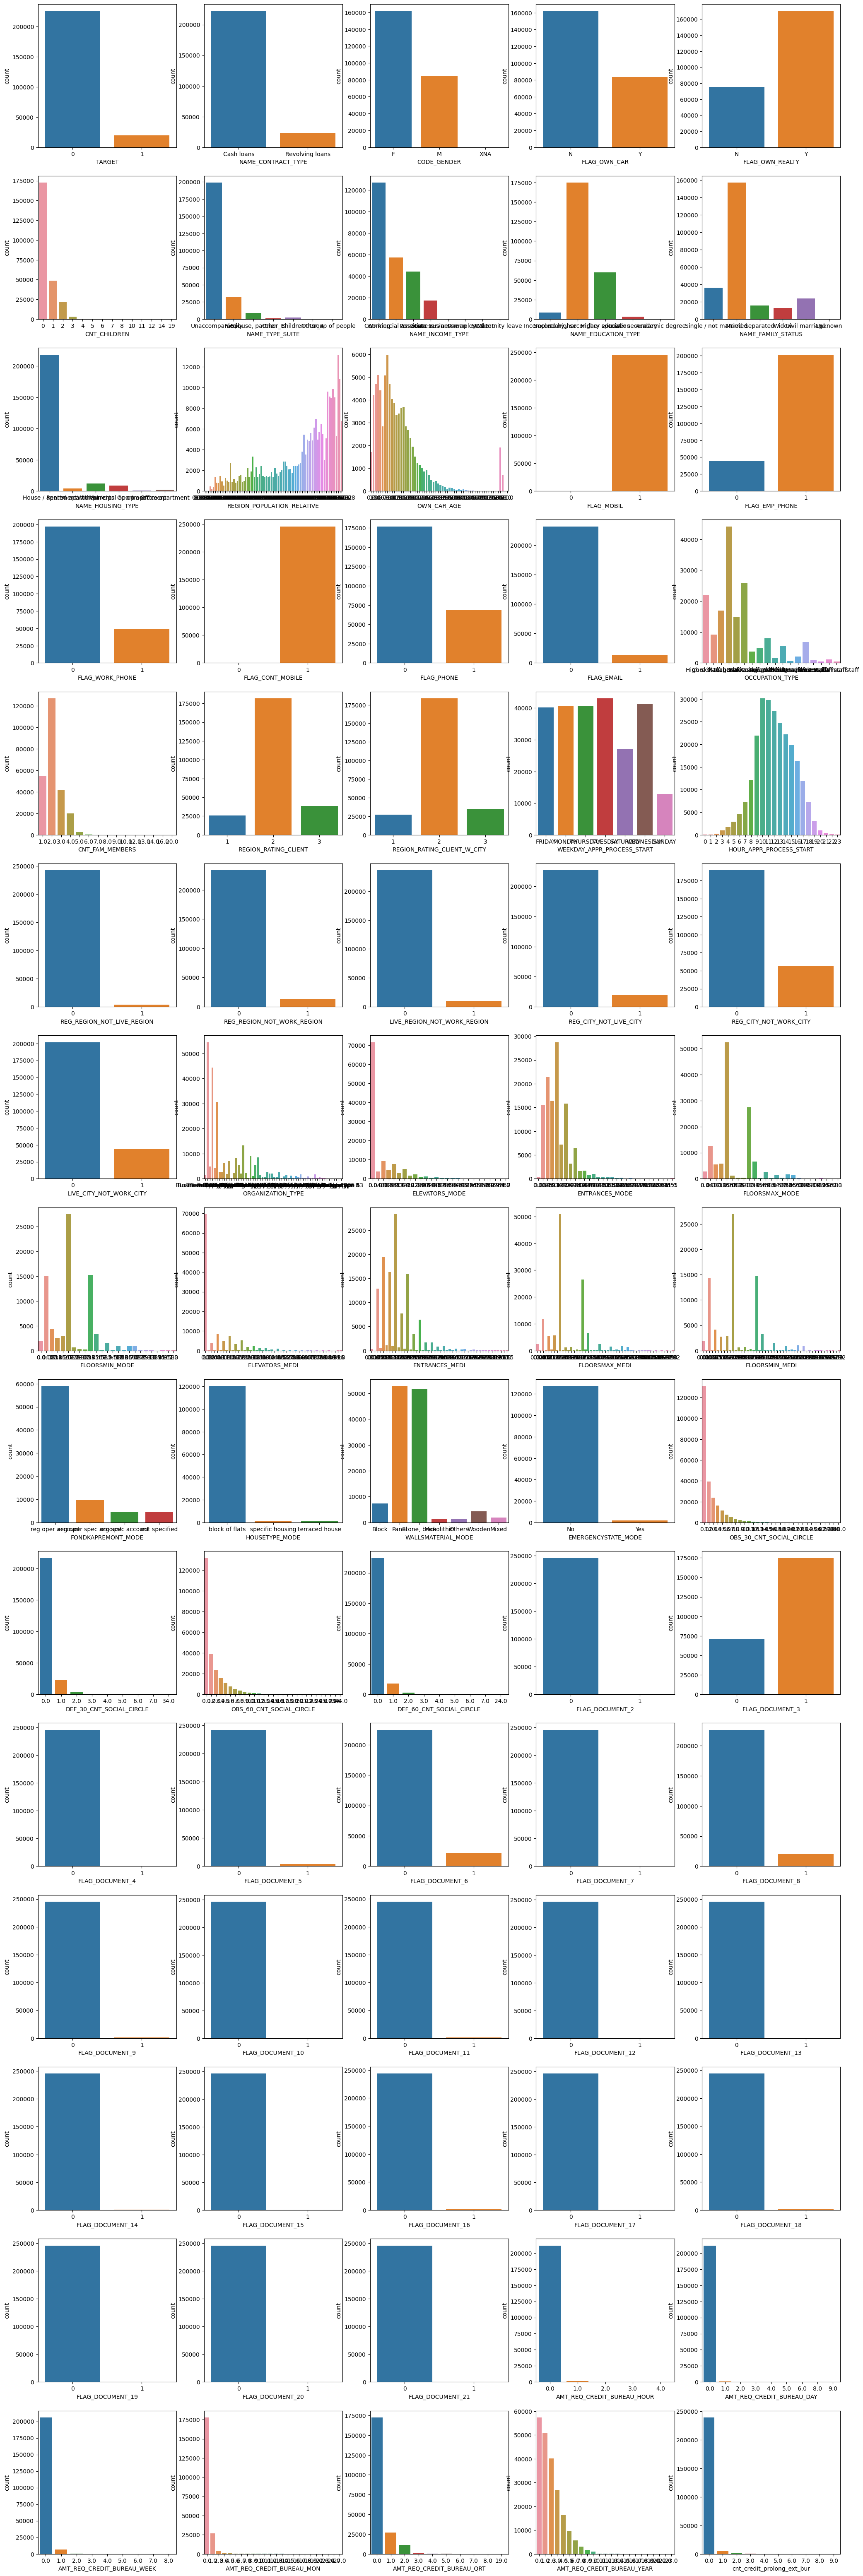

In [25]:
_ = df_train.nunique()
cat_cols = _[_<100].index

fig, axs = plt.subplots(nrows=15, ncols=5, figsize=(25, 80))
k = 0
for i in range(15):
    for j in range(5):
        if k < 75:
            sns.countplot(data=df_train, x=cat_cols[k], ax=axs[i][j])
            k += 1

## Education type new classification

In education we analise that the models only consider the higher education feature into account. Therefore we create a flag if the customer has ou has not higher eductaion. (By higher education we mean 'Academic degree' or 'Higher education')

In [26]:
df_train['flag_has_higher_education'] = np.where(df_train['NAME_EDUCATION_TYPE'].isin(['Academic degree', 'Higher education']), 1, 0)

df_train = df_train.drop(columns=['NAME_EDUCATION_TYPE'])

#df teste
df_test['flag_has_higher_education'] = np.where(df_test['NAME_EDUCATION_TYPE'].isin(['Academic degree', 'Higher education']), 1, 0)

df_test = df_test.drop(columns=['NAME_EDUCATION_TYPE'])

## Family status new classification

After an analysis, we conclude that exists a difference only if the customer was married once. Therefore we create a feature if the customer has married once.

In [27]:
df_train['NAME_FAMILY_STATUS'].unique()

array(['Single / not married', 'Married', 'Separated', 'Widow',
       'Civil marriage', 'Unknown'], dtype=object)

In [28]:
df_train['flag_has_married_once'] = np.where(df_train['NAME_FAMILY_STATUS'].isin(['Single / not married', 'Unknown']), 0, 1)

df_train = df_train.drop(columns=['NAME_FAMILY_STATUS'])

#df teste
df_test['flag_has_married_once'] = np.where(df_test['NAME_FAMILY_STATUS'].isin(['Single / not married', 'Unknown']), 0, 1)

df_test = df_test.drop(columns=['NAME_FAMILY_STATUS'])


## Phone and email info

There were several contact features. Some features were not explained in pre-models. Therefore we only will choose 'FLAG_PHONE' feature, this feature is a flag meaning that the client has or has not a phone in home.

In [29]:
contact_info = ['FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL']
# The only contact column it seems relevant in a pre model is 'FLAG_PHONE', which means that clients who provide a home phone may have not default
contact_info_to_drop = ['FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_EMAIL']

df_train.drop(columns=contact_info_to_drop)

#df test
df_test.drop(columns=contact_info_to_drop)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,dpd_internal_pos_cash,days_delayed_payment_inst_pay,amt_not_paid_inst_pay,dpd_cred_card_cd,var_credit_lim_cd,#_previous_refused_loan,to_pay_in_prev_app,days_employed,flag_has_higher_education,flag_has_married_once
0,149741,Cash loans,F,N,N,0,117000.0,417024.0,20191.5,360000.0,...,0.0,246.0,13530.510,0.0,0.0,2.0,-18853.252834,-2125,0,1
1,363290,Cash loans,M,N,Y,0,450000.0,640080.0,31261.5,450000.0,...,0.0,6.0,85334.805,0.0,0.0,1.0,-856126.517522,-2055,1,1
2,436006,Revolving loans,M,Y,Y,0,450000.0,900000.0,45000.0,900000.0,...,0.0,0.0,0.000,0.0,0.0,0.0,0.000000,-4159,1,0
3,377703,Cash loans,M,Y,N,1,360000.0,1125000.0,33025.5,1125000.0,...,0.0,0.0,0.000,0.0,0.0,0.0,-512313.494085,-2532,0,1
4,188624,Cash loans,M,Y,Y,0,675000.0,835380.0,42840.0,675000.0,...,8.0,22.0,346624.110,1.0,-90000.0,1.0,-429218.009663,-2516,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61498,102817,Cash loans,M,Y,N,0,225000.0,472500.0,46161.0,454500.0,...,0.0,0.0,0.000,0.0,0.0,0.0,-6845.988893,-3503,0,1
61499,343961,Cash loans,M,N,Y,0,112500.0,508495.5,24592.5,454500.0,...,0.0,16.0,220318.515,0.0,-135000.0,1.0,-72259.942014,0,0,1
61500,427828,Cash loans,F,Y,Y,0,157500.0,808650.0,23643.0,675000.0,...,0.0,-4.0,0.000,0.0,0.0,0.0,87073.172199,0,0,1
61501,405956,Cash loans,F,N,Y,0,202500.0,590337.0,30271.5,477000.0,...,0.0,5.0,9452.790,0.0,0.0,0.0,-28585.750010,-1381,0,1


Just to make clear, in email flag feature, we can see in what follows that the proportions of deafults is almost the same if the client has or has not email in contact info.

In [30]:
# We can see that email does not seems to give any help in explain customer default
df_train.groupby(['FLAG_EMAIL', 'TARGET'])['SK_ID_CURR'].count()

FLAG_EMAIL  TARGET
0           0         213184
            1          18869
1           0          12854
            1           1100
Name: SK_ID_CURR, dtype: int64

## Permanent address features selection

We only keep REG_CITY_NOT_LIVE_CITY, which means: "Flag if client's permanent address does not match contact address (1=different, 0=same, at city level)

In [31]:
perm_address_cols  = ['REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY']
# we only keep REG_CITY_NOT_LIVE_CITY, which means: "Flag if client's permanent address does not match contact address (1=different, 0=same, at city level)",
# one of the reason is that in pre model, this is the only permanent address feature that seems ok
perm_address_cols_to_drop = ['REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY']

df_train = df_train.drop(columns=perm_address_cols_to_drop)
df_test = df_test.drop(columns=perm_address_cols_to_drop)

## House Statistics selection

As we have a lot of customers house features, and several ones has about 70% of null values, we only keep with the total area average of each customer. this feature is the sum of living area average feature and non living area average.   

In [32]:
#house_info_cols = df_train.columns[44: 91]
house_info_cols_drop = ['APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG',
       'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG',
       'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG',
       'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG',
       'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE',
       'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE',
       'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE',
       'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE',
       'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI',
       'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI',
       'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI',
       'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI',
       'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI',
       'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'TOTALAREA_MODE',
       'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']

df_train['total_area_avg'] = df_train['LIVINGAREA_AVG'] + df_train['NONLIVINGAREA_AVG']
df_test['total_area_avg'] = df_test['LIVINGAREA_AVG'] + df_test['NONLIVINGAREA_AVG']

df_train = df_train.drop(columns=house_info_cols_drop)
df_test = df_test.drop(columns=house_info_cols_drop)

## Amount of requisitions Credit Bureau

For the requisitions in internal credit bureaus, we consider the sum of all requisition variables.

In [33]:
amt_requisitions_cols = ['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']

df_train['AMT_REQ_CREDIT_BUREAU_TOTAL'] = df_train[amt_requisitions_cols].sum(axis=1)
df_test['AMT_REQ_CREDIT_BUREAU_TOTAL'] = df_test[amt_requisitions_cols].sum(axis=1)

df_train = df_train.drop(columns=amt_requisitions_cols)
df_test = df_test.drop(columns=amt_requisitions_cols)

## Negative Columns

We see that some date features was recorded with negative values. As all features of the model is positive we will transform these features to be posisitive taking the absolute value. 


As all features are recorded in days, to get a low variance we transform these feature in annual features.

In [34]:
df_train['years_birth_age_'] = abs(df_train['DAYS_BIRTH']) / 365
df_train['years_registration'] = abs(df_train['DAYS_REGISTRATION']) / 365
df_train['years_id_published'] = abs(df_train['DAYS_ID_PUBLISH']) / 365
df_train['years_employed'] = abs(df_train['days_employed']) / 365
df_train['years_last_phone_change'] = abs(df_train['DAYS_LAST_PHONE_CHANGE']) / 365

df_train = df_train.drop(columns=['DAYS_BIRTH', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE', 'days_employed'])

# Test
df_test['years_birth_age_'] = abs(df_test['DAYS_BIRTH']) / 365
df_test['years_registration'] = abs(df_test['DAYS_REGISTRATION']) / 365
df_test['years_id_published'] = abs(df_test['DAYS_ID_PUBLISH']) / 365
df_test['years_employed'] = abs(df_test['days_employed']) / 365
df_test['years_last_phone_change'] = abs(df_test['DAYS_LAST_PHONE_CHANGE']) / 365

df_test = df_test.drop(columns=['DAYS_BIRTH', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE', 'days_employed'])

## Documents Features

In the following table we can see that documents features in general was flagged with 0, meaning that a small amount of customers delivered the respective document. We see very low correlations with 'TARGET' for all documents.

We only select the documents with more than 1% of customers has delivered.

In [35]:
from scipy.stats import pearsonr
documents = []
for i in range(2,22):
    documents.append(f'FLAG_DOCUMENT_{i}')
cols_df = {}

for doc in documents:
    _ = df_train[df_train[doc] == 1]['TARGET'].value_counts(normalize=True) * 100
    if len(_) == 2:
        cols_df[doc] = [round(_[0], 2), round(_[1], 2), round(len(df_train[df_train[doc] == 1])/len(df_train)*100, 2), pearsonr(df_train[doc], df_train['TARGET'])[0]] 
    else:
        cols_df[doc] = [round(_[0], 2), 0, round(len(df_train[df_train[doc] == 1])/len(df_train)*100, 2), pearsonr(df_train[doc], df_train['TARGET'])[0]]

doc_info = pd.DataFrame(cols_df).T.rename(columns={0: 'PERC_W_TARGET_0', 1: 'PERC_W_TARGET_1', 2: 'PERC_CUST_PROVIDE_THIS_DOC', 3: 'CORR_DOC_TARGET'})
doc_info

,PERC_W_TARGET_0,PERC_W_TARGET_1,PERC_CUST_PROVIDE_THIS_DOC,CORR_DOC_TARGET
FLAG_DOCUMENT_2,70.00,30.00,0.00,0.005109
FLAG_DOCUMENT_3,91.12,8.88,71.08,0.044065
FLAG_DOCUMENT_4,100.00,0.00,0.01,-0.002746
FLAG_DOCUMENT_5,92.17,7.83,1.51,-0.001288
FLAG_DOCUMENT_6,94.32,5.68,8.79,-0.027747
FLAG_DOCUMENT_7,95.74,4.26,0.02,-0.001955
FLAG_DOCUMENT_8,92.58,7.42,8.11,-0.007609
FLAG_DOCUMENT_9,93.40,6.60,0.38,-0.003450
FLAG_DOCUMENT_10,100.00,0.00,0.00,-0.001038
FLAG_DOCUMENT_11,94.17,5.83,0.39,-0.005251


In [36]:
documents_to_select = ['FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_16']
documents_to_discard = ['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']

df_train = df_train.drop(columns=documents_to_discard)
df_test = df_test.drop(columns=documents_to_discard)

## Observations of default

We normalize the observations of default in social circle of each customer.

In [37]:
df_train['pct_30'] = df_train['DEF_30_CNT_SOCIAL_CIRCLE']/df_train['OBS_30_CNT_SOCIAL_CIRCLE']
df_train['pct_60'] = df_train['DEF_60_CNT_SOCIAL_CIRCLE']/df_train['OBS_60_CNT_SOCIAL_CIRCLE']
df_train.drop(['OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE'], axis=1, inplace=True)

In [38]:
df_test['pct_30'] = df_test['DEF_30_CNT_SOCIAL_CIRCLE']/df_test['OBS_30_CNT_SOCIAL_CIRCLE']
df_test['pct_60'] = df_test['DEF_60_CNT_SOCIAL_CIRCLE']/df_test['OBS_60_CNT_SOCIAL_CIRCLE']
df_test.drop(['OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE'], axis=1, inplace=True)

## Combining External Sources Features

We will combine the 3 external sources features into one by taking the mean of all not null values in the three columns

In [39]:
scores = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']
_ = df_train[scores]
_['mean'] = _.sum(axis=1)
_['non_missing'] = 3-_[scores].isna().sum(axis=1)
_['new_score'] = _['mean'] / _['non_missing']
df_train['score_mean'] = _['new_score']

df_train = df_train.drop(columns=scores)

In [40]:
scores = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']
_ = df_test[scores]
_['mean'] = _.sum(axis=1)
_['non_missing'] = 3-_[scores].isna().sum(axis=1)
_['new_score'] = _['mean'] / _['non_missing']
df_test['score_mean'] = _['new_score']

df_test = df_test.drop(columns=scores)

# Pre processing and modeling

We will apply the models that perform best in our case. Then we will make a feature selection to create o more explanative and simple model.

In [41]:
print(f"Train and validation dataset shape: {df_train.shape}")
print(f"Test dataset shape: {df_test.shape}")

Train and validation dataset shape: (246007, 60)
Test dataset shape: (61503, 59)


**PRE PROCESSING STEPS:**

As the dataframe is unbalanced we will balance the train using oversampling.

We will input the missing numeric values with the median and the categorical with the most frequent 

In [42]:
features_to_drop_model = ['SK_ID_CURR', 'TARGET', 'CODE_GENDER']

X = df_train.drop(columns=features_to_drop_model)
y = df_train['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

oversample = RandomOverSampler(sampling_strategy='minority')
X_train, y_train = oversample.fit_resample(X_train, y_train)

X_num_cols = X_train.select_dtypes(include='number').columns
X_cat_cols = X_train.select_dtypes(exclude='number').columns

num_transformer = Pipeline(steps = [('imputer_num', SimpleImputer(missing_values=np.nan, strategy='median')), 
                                    ('std_scaler', MinMaxScaler())])

cat_transformer = Pipeline(steps = [('cat_imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')), 
                                    ('cat_dummies', OneHotEncoder(drop= 'first'))])

ct = ColumnTransformer([('num', num_transformer, X_num_cols),
                        ('cat', cat_transformer, X_cat_cols)])

Logistic Regression model

              precision    recall  f1-score   support

           0       0.96      0.69      0.81     45208
           1       0.16      0.67      0.26      3994

    accuracy                           0.69     49202
   macro avg       0.56      0.68      0.53     49202
weighted avg       0.89      0.69      0.76     49202



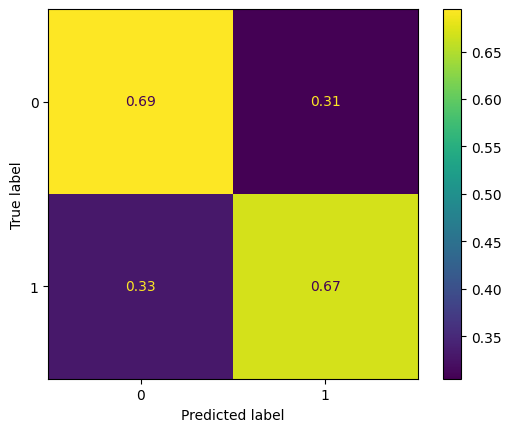

In [43]:
model_lr = Pipeline(steps = [('column_transformer', ct), 
                             ('model', LogisticRegression(random_state=42, penalty='l1', solver= 'liblinear'))])

model_lr.fit(X_train, y_train)
y_pred = model_lr.predict(X_test)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, normalize='true')).plot()

roc = roc_auc_score(y_test, model_lr.predict_proba(X_test)[:,1])
# print(f'ROC_AUC score = {roc}')

# Feature selection using Gradient Boosting Classifier feature importances

              precision    recall  f1-score   support

           0       0.96      0.71      0.81     45208
           1       0.17      0.67      0.27      3994

    accuracy                           0.70     49202
   macro avg       0.56      0.69      0.54     49202
weighted avg       0.90      0.70      0.77     49202

ROC_AUC score = 0.7537108008943162


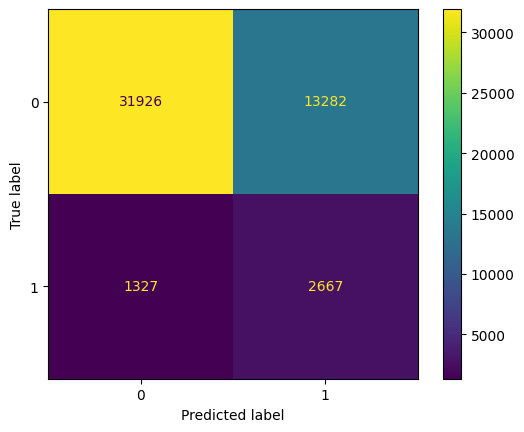

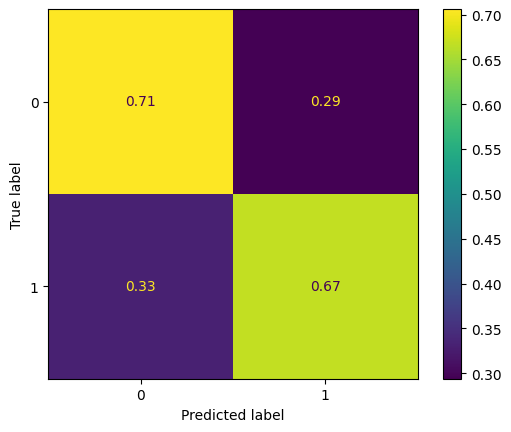

In [44]:
model_gb = Pipeline(steps = [('column_transformer', ct), ('model', GradientBoostingClassifier(learning_rate = 0.4, n_estimators = 80, random_state=42))])

model_gb.fit(X_train, y_train)
y_pred = model_gb.predict(X_test)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot();
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, normalize='true')).plot();
roc = roc_auc_score(y_test, model_gb.predict_proba(X_test)[:,1])
print(f'ROC_AUC score = {roc}')

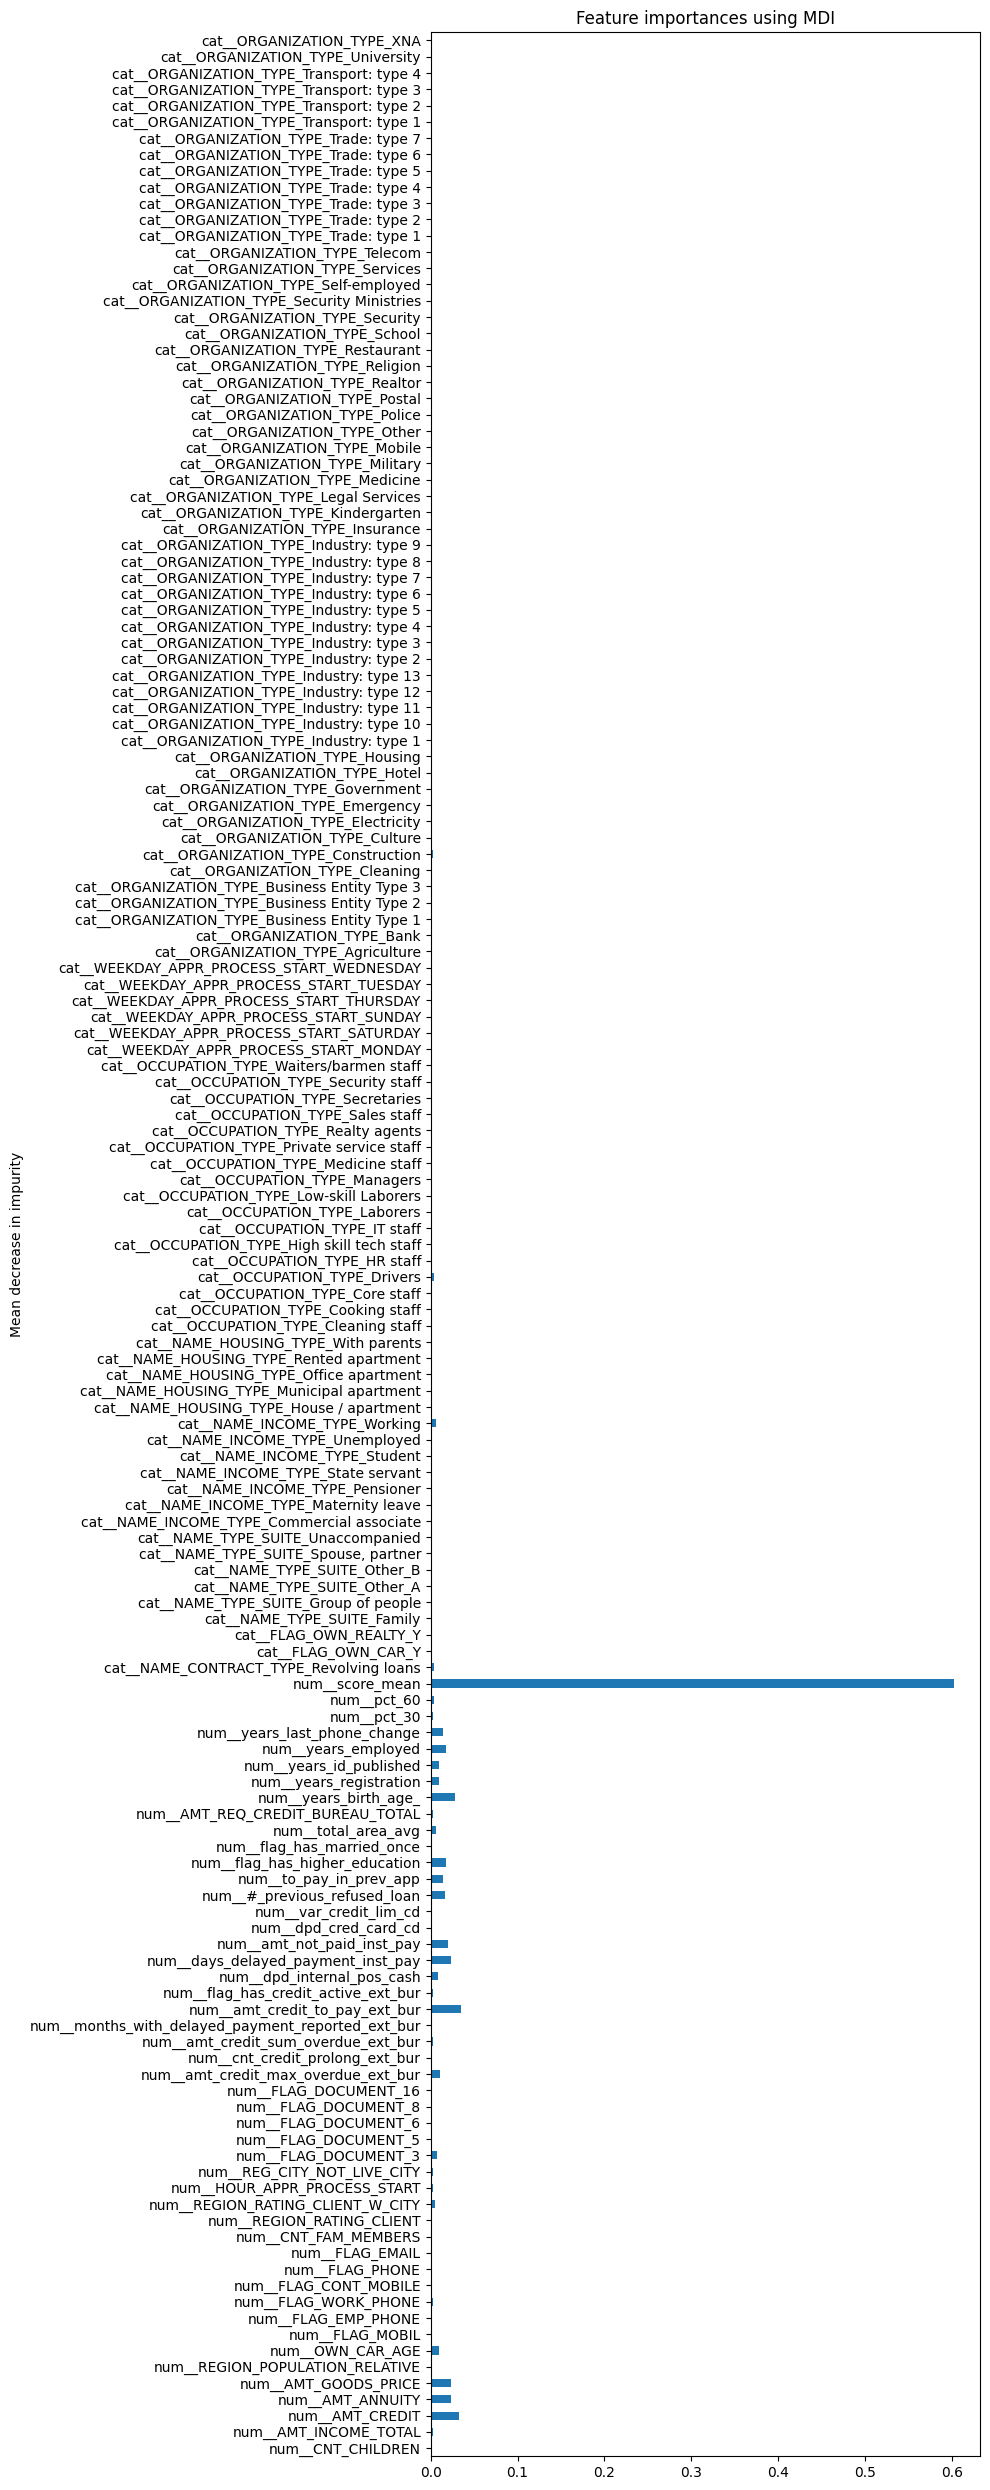

In [45]:
importances = model_gb.named_steps['model'].feature_importances_
feature_names = model_gb.named_steps['column_transformer'].get_feature_names_out()
df_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize=(10,25))
df_importances.plot.barh(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Extracting the features with more than 1% importances

In [46]:
_ = df_importances.reset_index()

features = _[_[0]>=0.01]['index'].tolist()

# formating the features extracted names
principal_features = []

for f in features:
    principal_features.append(f[5:])
    
print(principal_features)

['AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'amt_credit_max_overdue_ext_bur', 'amt_credit_to_pay_ext_bur', 'days_delayed_payment_inst_pay', 'amt_not_paid_inst_pay', '#_previous_refused_loan', 'to_pay_in_prev_app', 'flag_has_higher_education', 'years_birth_age_', 'years_employed', 'years_last_phone_change', 'score_mean']


Features sected explained:

* 'AMT_CREDIT': Credit amount of the loan  

* 'AMT_ANNUITY': Loan annuity 

* 'AMT_GOODS_PRICE': For consumer loans it is the price of the goods for which the loan is given

* 'amt_credit_to_pay_ext_bur': Amount of credit to pay reported in external bureaus 

* 'days_delayed_payment_inst_pay': Sum of days the customer delayed payments in Home Credit

* 'amt_not_paid_inst_pay': Sum of amount not paid in previous applications in Home Credit

* '#_previous_refused_loan': Number of times the client has refused loans in previous applications in Home Credit 

* 'to_pay_in_prev_app': Amount to pay in previous loans in Home Credit

* 'flag_has_higher_education': Flag if client has higher education

* 'years_birth_age_': Age of the customer

* 'years_id_published': Years since the customer made his first registration in Home Credit

* 'years_employed': Years employed

* 'years_last_phone_change': Years since the customer change the phone number

* 'score_mean': Mean of avaiable external scores for each customer

Adaptating the pre-processing to new datasets

In [47]:
# pf here stands for principal features
X_train_pf = X_train[principal_features]
X_test_pf = X_test[principal_features]

X_num_cols = X_train_pf.select_dtypes(include='number').columns
X_cat_cols = X_train_pf.select_dtypes(exclude='number').columns

num_transformer = Pipeline(steps = [('imputer_num', SimpleImputer(missing_values=np.nan, strategy='median')), 
                                    ('std_scaler', MinMaxScaler())])

cat_transformer = Pipeline(steps = [('cat_imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')), 
                                    ('cat_dummies', OneHotEncoder(drop= 'first'))])

ct = ColumnTransformer([('num', num_transformer, X_num_cols),
                        ('cat', cat_transformer, X_cat_cols)])

Training models with the features selected

# Gradient boosting with selected features

              precision    recall  f1-score   support

           0       0.96      0.70      0.81     45208
           1       0.16      0.67      0.26      3994

    accuracy                           0.70     49202
   macro avg       0.56      0.68      0.54     49202
weighted avg       0.89      0.70      0.76     49202

ROC_AUC score = 0.7480809256930875


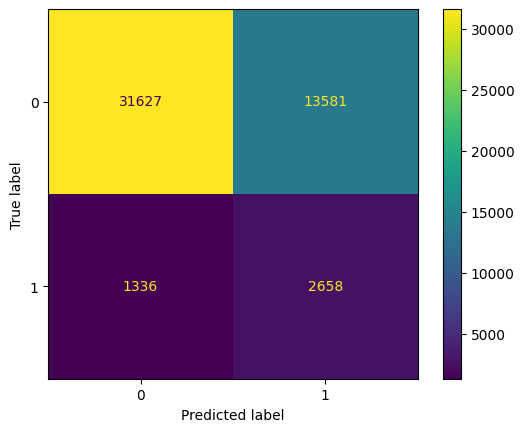

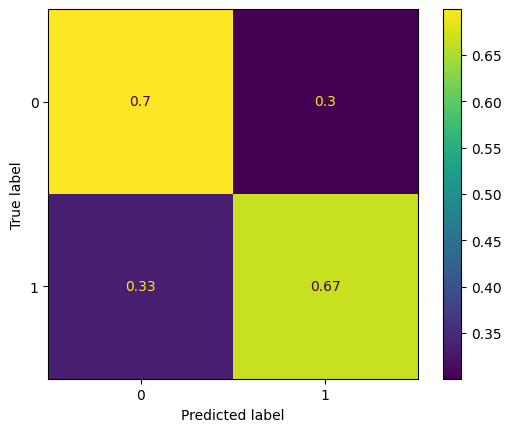

In [48]:
model_gb_pf = Pipeline(steps = [('column_transformer', ct), ('model', GradientBoostingClassifier(learning_rate = 0.4, n_estimators = 80, random_state=42))])

model_gb_pf.fit(X_train_pf, y_train)
y_pred = model_gb_pf.predict(X_test_pf)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot();
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, normalize='true')).plot();

roc = roc_auc_score(y_test, model_gb_pf.predict_proba(X_test_pf)[:,1])
print(f'ROC_AUC score = {roc}')

### Gradient boosting with selected features and Optimized Parameters with GridSearchCV

              precision    recall  f1-score   support

           0       0.96      0.72      0.82     45208
           1       0.16      0.62      0.26      3994

    accuracy                           0.72     49202
   macro avg       0.56      0.67      0.54     49202
weighted avg       0.89      0.72      0.78     49202

ROC_AUC score = 0.7293178696996122


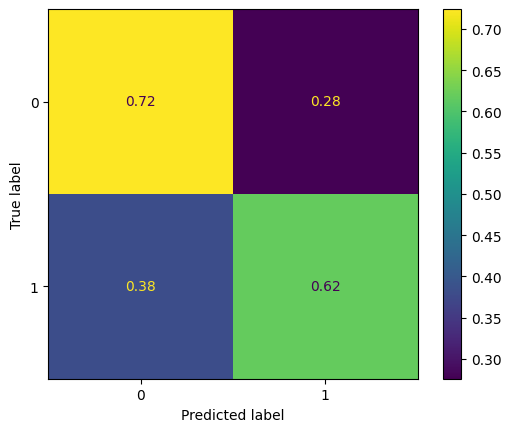

In [49]:
model_gb = Pipeline(steps = [('column_transformer', ct), ('model', GradientBoostingClassifier(learning_rate = 0.6, max_depth=4, n_estimators = 140, random_state=42))])

model_gb.fit(X_train, y_train)
y_pred = model_gb.predict(X_test)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, normalize='true')).plot()

roc = roc_auc_score(y_test, model_gb.predict_proba(X_test)[:,1])
print(f'ROC_AUC score = {roc}')

              precision    recall  f1-score   support

           0       0.95      0.78      0.86     45208
           1       0.18      0.56      0.27      3994

    accuracy                           0.76     49202
   macro avg       0.57      0.67      0.56     49202
weighted avg       0.89      0.76      0.81     49202

roc_auc_score: 0.6677132359306968
f1 score: 0.27342888643880925


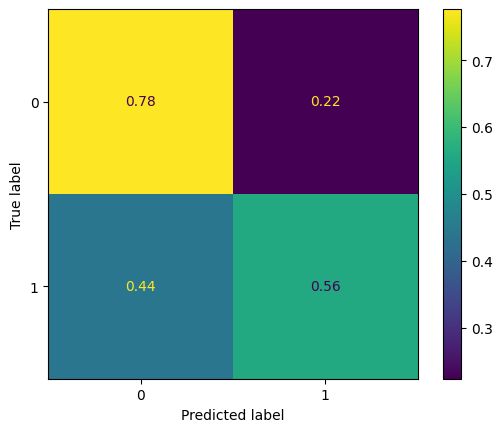

In [50]:
# Choosing the best cuttoff
y_pred = np.where(model_gb.predict_proba(X_test)[:,1]>= 0.55, 1, 0)
print(classification_report(y_test,y_pred))
print(f"roc_auc_score: {roc_auc_score(y_test,y_pred)}")
print(f"f1 score: {f1_score(y_test,y_pred)}")
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, normalize='true')).plot();

# Other tests

 XGBoost

              precision    recall  f1-score   support

           0       0.96      0.74      0.83     45208
           1       0.17      0.61      0.26      3994

    accuracy                           0.73     49202
   macro avg       0.56      0.67      0.55     49202
weighted avg       0.89      0.73      0.79     49202

ROC_AUC score = 0.738256309987012


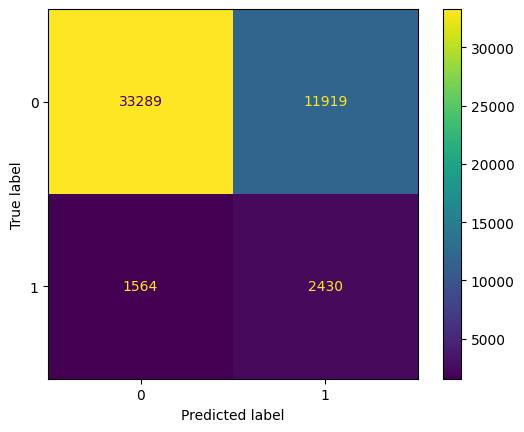

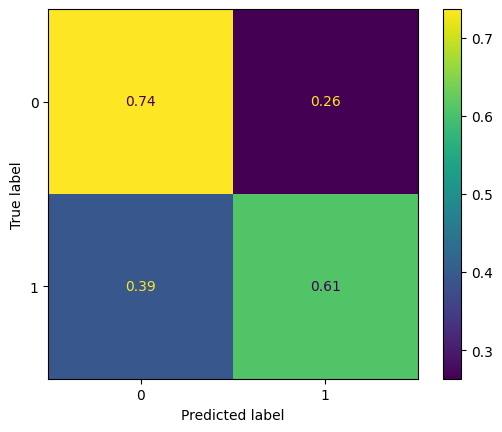

In [53]:
import xgboost as xgb

model_xgb = Pipeline(steps = [('column_transformer', ct), ('model', xgb.XGBClassifier(random_state=42))])

model_xgb.fit(X_train_pf, y_train)
y_pred = model_xgb.predict(X_test_pf)
print(classification_report(y_test, y_pred))

roc = roc_auc_score(y_test, model_xgb.predict_proba(X_test_pf)[:,1])
print(f'ROC_AUC score = {roc}')

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot();
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, normalize='true')).plot();

XGBoost optimized

              precision    recall  f1-score   support

           0       0.96      0.72      0.82     45208
           1       0.17      0.64      0.27      3994

    accuracy                           0.71     49202
   macro avg       0.56      0.68      0.55     49202
weighted avg       0.89      0.71      0.78     49202

ROC_AUC score = 0.7479524176992796


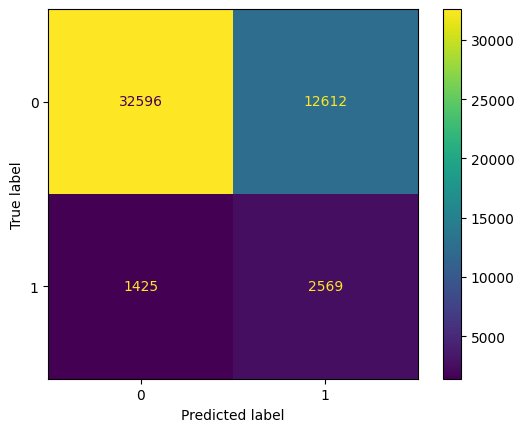

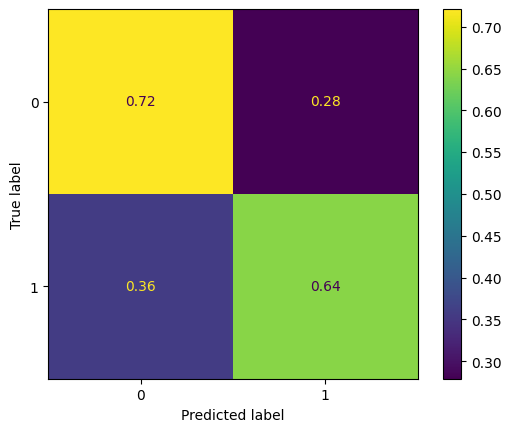

In [54]:
model_xgb = Pipeline(steps = [
    ('column_transformer', ct), 
    ('model', xgb.XGBClassifier(random_state=42, gamma=1.1, learning_rate=0.15, max_depth=6, reg_lambda=15.0))
])

model_xgb.fit(X_train_pf, y_train)
y_pred = model_xgb.predict(X_test_pf)
print(classification_report(y_test, y_pred))

roc = roc_auc_score(y_test, model_xgb.predict_proba(X_test_pf)[:,1])
print(f'ROC_AUC score = {roc}')

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot();
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, normalize='true')).plot()

              precision    recall  f1-score   support

           0       0.95      0.71      0.82     45208
           1       0.15      0.58      0.24      3994

    accuracy                           0.70     49202
   macro avg       0.55      0.64      0.53     49202
weighted avg       0.89      0.70      0.77     49202

ROC_AUC score = 0.6831048975693234


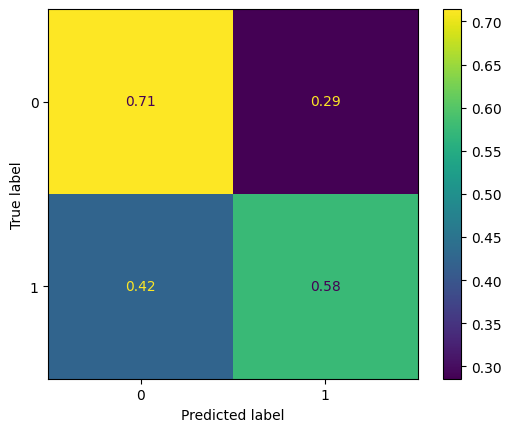

In [55]:
#Import Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB

model_nb = Pipeline(steps = [('column_transformer', ct), ('model', GaussianNB())])
model_nb.fit(X_train_pf, y_train)
y_pred = model_nb.predict(X_test_pf)
print(classification_report(y_test, y_pred))
roc = roc_auc_score(y_test, model_nb.predict_proba(X_test_pf)[:,1])
print(f'ROC_AUC score = {roc}')
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, normalize='true')).plot()
plt.show()

#### Light Gradient Boost Model Classifier

              precision    recall  f1-score   support

           0       0.96      0.71      0.81     45208
           1       0.17      0.67      0.27      3994

    accuracy                           0.70     49202
   macro avg       0.56      0.69      0.54     49202
weighted avg       0.90      0.70      0.77     49202

ROC_AUC score = 0.7531733086711999


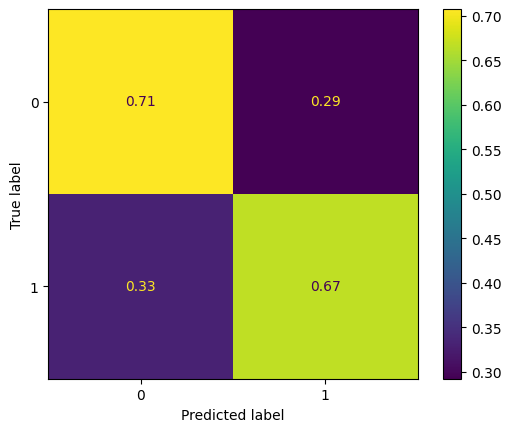

In [57]:
#This model was tunned with GridSearchCV
model_lgb = Pipeline(steps = [('column_transformer', ct), ('model', LGBMClassifier( learning_rate = 0.2, 
                                                                                    n_estimators = 400,
                                                                                    max_depth=3,
                                                                                    reg_lambda = 10.59,
                                                                                    reg_alpha = 110,
                                                                                    max_bin = 500,
                                                                                    min_child_weight = 0.1,
                                                                                    min_child_samples = 20,
                                                                                    random_state=42))])
model_lgb.fit(X_train_pf, y_train)
y_pred = model_lgb.predict(X_test_pf)
print(classification_report(y_test, y_pred))
roc = roc_auc_score(y_test, model_lgb.predict_proba(X_test_pf)[:,1])
print(f'ROC_AUC score = {roc}')
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, normalize='true')).plot()
plt.show()

In [76]:
model_lgb_final = Pipeline(steps = [ ('column_transformer', ct), 
                                    ('model', LGBMClassifier(learning_rate = 0.2, 
                                                             n_estimators = 400,
                                                             max_depth=3,
                                                             reg_lambda = 10.59,
                                                             reg_alpha = 110,
                                                             max_bin = 500,
                                                             min_child_weight = 0.1,
                                                             min_child_samples = 20,
                                                             random_state=42))])

X = df_train[principal_features]
y = df_train['TARGET']

oversample = RandomOverSampler(sampling_strategy='minority')
X_train, y_train = oversample.fit_resample(X, y)

model_lgb_final.fit(X, y)
y_pred = model_lgb_final.predict(df_test[principal_features])
y_predict_proba = model_lgb_final.predict_proba(df_test[principal_features])[:,1]

ids = df_test['SK_ID_CURR']
answer = pd.DataFrame()
answer['SK_ID_CURR'] = ids
answer['TARGET'] = y_predict_proba
answer.to_csv("submission.csv", index= False)

## Sequential Models

### Gradient Boost + Light Gradient Boost 

              precision    recall  f1-score   support

           0       0.96      0.70      0.81     45208
           1       0.16      0.67      0.26      3994

    accuracy                           0.70     49202
   macro avg       0.56      0.68      0.54     49202
weighted avg       0.89      0.70      0.76     49202

ROC_AUC score = 0.7480809256930875


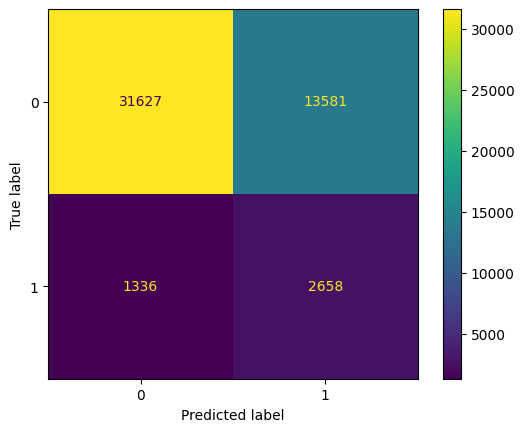

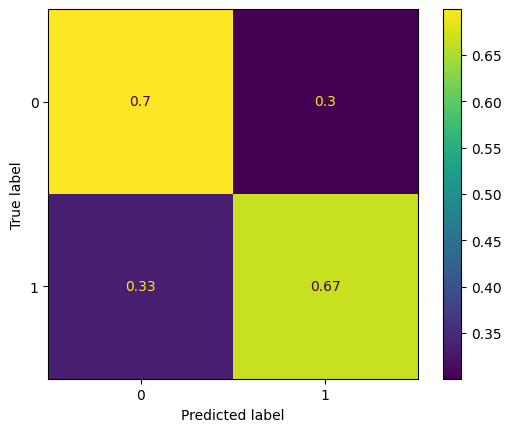

In [70]:
model_gb_pf = Pipeline(steps = [('column_transformer', ct), ('model', GradientBoostingClassifier(learning_rate = 0.4, n_estimators = 80, random_state=42))])

model_gb_pf.fit(X_train_pf, y_train)
y_pred = model_gb_pf.predict(X_test_pf)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot();
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, normalize='true')).plot();

roc = roc_auc_score(y_test, model_gb_pf.predict_proba(X_test_pf)[:,1])
print(f'ROC_AUC score = {roc}')

In [71]:
X_test_pf_0 = X_test_pf[y_pred==0]
y_test_0 = y_test[y_pred==0]

X_test_pf_1 = X_test_pf[y_pred==1]
y_test_1 = y_test[y_pred==1]

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     31627
           1       0.09      0.10      0.10      1336

    accuracy                           0.92     32963
   macro avg       0.53      0.53      0.53     32963
weighted avg       0.93      0.92      0.92     32963



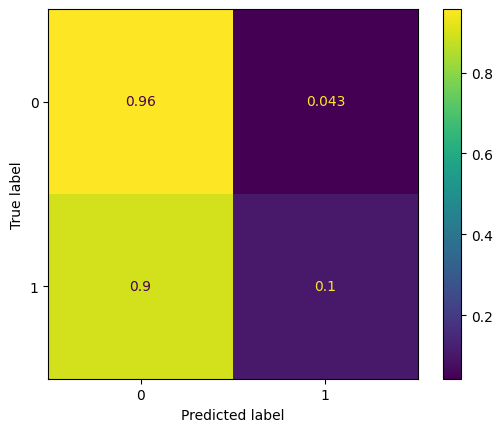

In [72]:
#Como o resultado do que predizemos como 1 foi bom, iremos fazer um novo modelo para o X_test_0
model_nb = Pipeline(steps = [('column_transformer', ct), ('model', LGBMClassifier( learning_rate = 0.2, 
                                                                                    n_estimators = 400,
                                                                                    max_depth=3,
                                                                                    reg_lambda = 10.59,
                                                                                    reg_alpha = 110,
                                                                                    max_bin = 500,
                                                                                    min_child_weight = 0.1,
                                                                                    min_child_samples = 20,
                                                                                    random_state=42))])
model_nb.fit(X_train_pf, y_train)
y_pred_0 = model_nb.predict(X_test_pf_0)
print(classification_report(y_test_0, y_pred_0))
ConfusionMatrixDisplay(confusion_matrix(y_test_0, y_pred_0, normalize="true")).plot()

Text(0.5, 0, 'cutoffs')

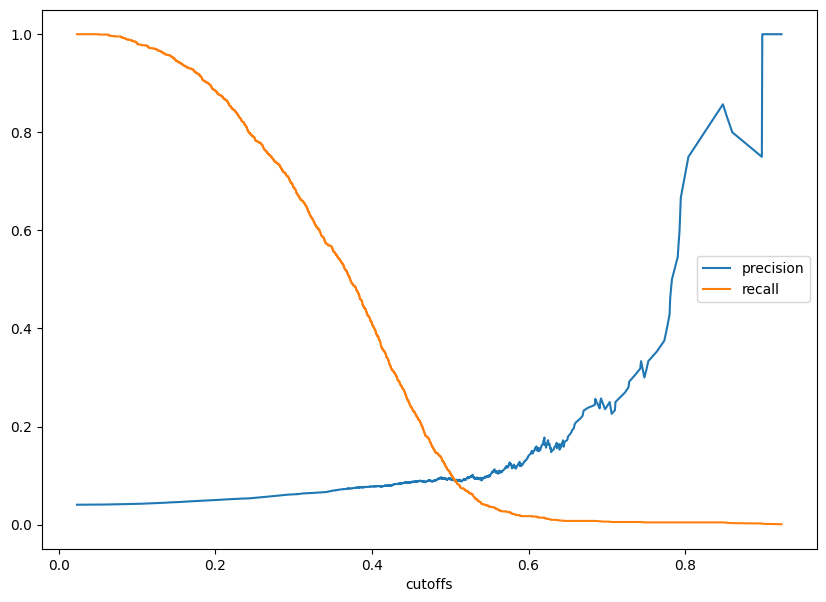

In [73]:
precisions, recalls, cutoffs = precision_recall_curve(y_test_0, model_nb.predict_proba(X_test_pf_0)[:,1])
plt.figure(figsize=(10,7))
plt.plot(cutoffs, precisions[:-1], label='precision')
plt.plot(cutoffs, recalls[:-1], label='recall')
plt.legend()

plt.xlabel('cutoffs')

              precision    recall  f1-score   support

           0       0.97      0.79      0.87     31627
           1       0.08      0.41      0.13      1336

    accuracy                           0.78     32963
   macro avg       0.52      0.60      0.50     32963
weighted avg       0.93      0.78      0.84     32963

roc_auc_score: 0.6014071155756593
f1 score: 0.13010842368640532


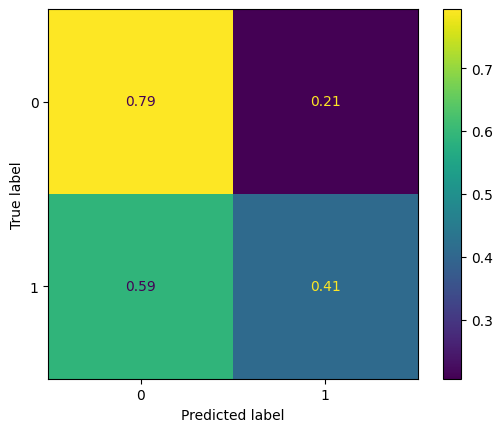

In [74]:
# Choosing the best cuttoff
y_pred_best_0 = np.where(model_nb.predict_proba(X_test_pf_0)[:,1]>= 0.4, 1, 0)
print(classification_report(y_test_0,y_pred_best_0))
print(f"roc_auc_score: {roc_auc_score(y_test_0,y_pred_best_0)}")
print(f"f1 score: {f1_score(y_test_0,y_pred_best_0)}")
ConfusionMatrixDisplay(confusion_matrix(y_test_0, y_pred_best_0,normalize="true")).plot()

<class 'pandas.core.series.Series'>
Int64Index: 49202 entries, 17062 to 243472
Series name: TARGET
Non-Null Count  Dtype
--------------  -----
49202 non-null  int64
dtypes: int64(1)
memory usage: 768.8 KB
              precision    recall  f1-score   support

           0       0.97      0.56      0.71     45208
           1       0.14      0.80      0.23      3994

    accuracy                           0.58     49202
   macro avg       0.55      0.68      0.47     49202
weighted avg       0.90      0.58      0.67     49202

roc_auc_score: 0.6788843458073325
f1 score: 0.2348112861854159


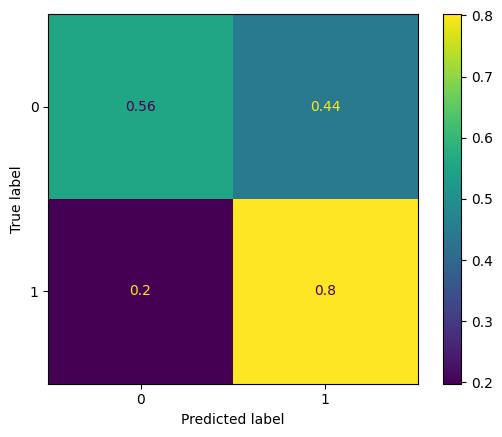

In [75]:
# Concatenating for total result
y_test_total = pd.concat([y_test_0,y_test_1], axis=0)
y_test_total.info()
y_pred_total = np.concatenate([y_pred_best_0, y_pred[y_pred==1]])
print(classification_report(y_test_total, y_pred_total))
print(f"roc_auc_score: {roc_auc_score(y_test_total,y_pred_total)}")
print(f"f1 score: {f1_score(y_test_total,y_pred_total)}")
ConfusionMatrixDisplay(confusion_matrix(y_test_total, y_pred_total, normalize="true")).plot()

In [ ]:
# #Tunning parameters with GridSearchCV

# model_xgb = Pipeline(steps = [('column_transformer', ct), 
#                     ('model', xgb.XGBClassifier(objective='binary:logistic', random_state=42))])

# param_grid = {
#     'model__max_depth': [3, 4, 5],
#     'model__learning_rate': [0.1, 0.05, 0.01],
#     'model__gamma': [0, 0.25, 1.0],
#     'model__reg_lambda': [0, 1.0, 10.0],
#     'model__scale_pos_weight': [1, weight-3, weight, weight+3]
# }

# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# grid_ab = GridSearchCV(
#     estimator=model_xgb,
#     param_grid=param_grid,
#     scoring='roc_auc',
#     cv=cv,
#     verbose=3,
#     n_jobs=31
# )

# grid_ab.fit(X_train, y_train, model__early_stopping_rounds=10, model__eval_metric = 'auc', model__eval_set = [(teste, y_test)])

# print(grid_ab.best_params_)